<a href="https://colab.research.google.com/github/miladbahrami-fs/Independent_Causal_Mechanisms/blob/main/LICM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 32.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


In [2]:
# Importing Libraries
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset
import torch
import time
import os
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt

In [3]:
# Constants
outdir = '.' #path to the output directory
optimizer_experts = 'adam' # optimization algorithm (options: sgd | adam)
optimizer_discriminator ='adam' # optimization algorithm (options: sgd | adam)
optimizer_initialize ='adam' # optimization algorithm (options: sgd | adam)
batch_size = 32 # input batch size for training
input_size = 784 # input size of data
epochs = 100 # number of epochs to train
epochs_init = 100 # number of epochs to initially train experts
no_cuda = False # enables CUDA training
seed = 11 # random seed
log_interval = 10 # how many batches to wait before logging training status
learning_rate_initialize = 1e-1 # size of expert learning rate
learning_rate_expert = 1e-3 #size of expert learning rate
learning_rate_discriminator =1e-3 # size of discriminator learning rate
name = '' #name of experiment
weight_decay = 0 # weight decay for optimizer
num_experts = 5 # number of experts
load_initialized_experts = False # whether to load already pre-trained experts
model_for_initialized_experts ='' # path to pre-trained experts
cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [4]:
# Load dataset Original
transform_org = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
dataset_train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform_org
)

dataset_test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform_org
)

# Create Dataloader from orginal dataset
data_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=int(cuda), pin_memory=cuda)

100%|██████████| 9912422/9912422 [00:00<00:00, 282073851.84it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 44033331.09it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 182506238.37it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 7418430.21it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



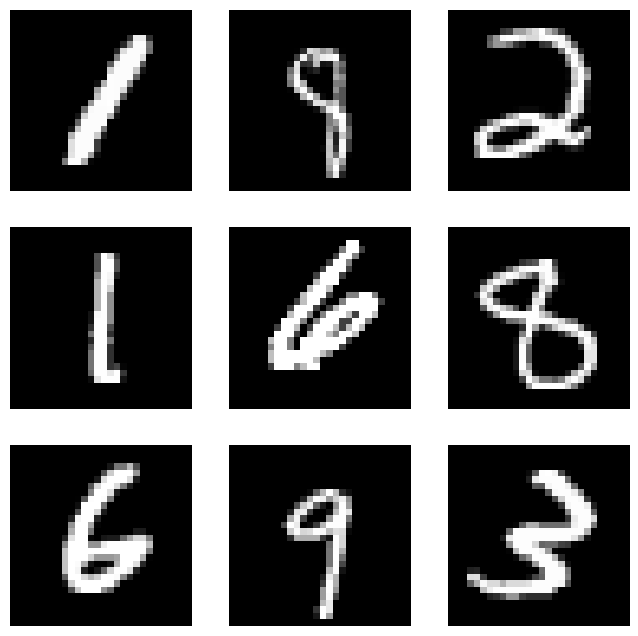

Train Size: 60000, Test Size: 10000


In [5]:
# Show Sample Data from Orginal Dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset_train), size=(1,)).item()
    img, label = dataset_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Train and Test Dataset Size
print('Train Size: {}, Test Size: {}'.format(len(dataset_train),len(dataset_test)))

In [6]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [7]:
# Dataset with added Gaussian Noise
transform_noise = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.25),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset_train_noise = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform_noise
)
data_train_noise = DataLoader(dataset_train_noise, batch_size=batch_size, shuffle=True, num_workers=int(cuda), pin_memory=cuda)

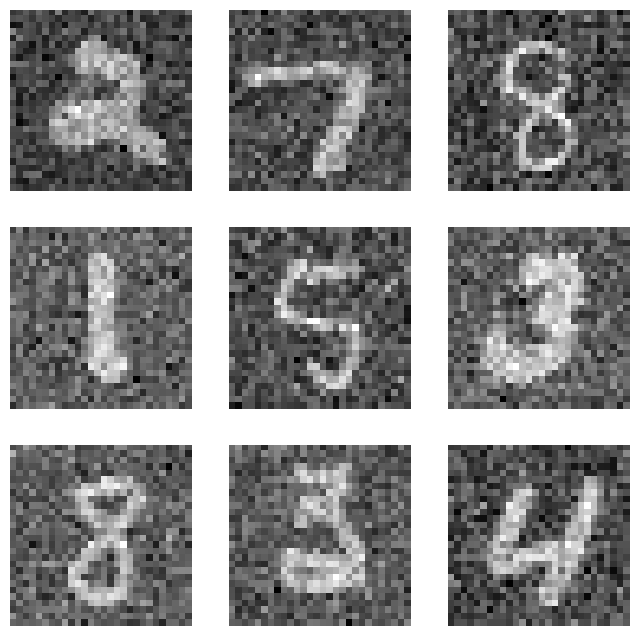

In [8]:
# Show Sample Data from Noise Added Dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset_train_noise), size=(1,)).item()
    img, label = dataset_train_noise[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [9]:
# Dataset of Inverted images
transform_negative = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: transforms.functional.invert(x)),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset_train_negative = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform_negative
)
data_train_negative = DataLoader(dataset_train_negative, batch_size=batch_size, shuffle=True, num_workers=int(cuda), pin_memory=cuda)

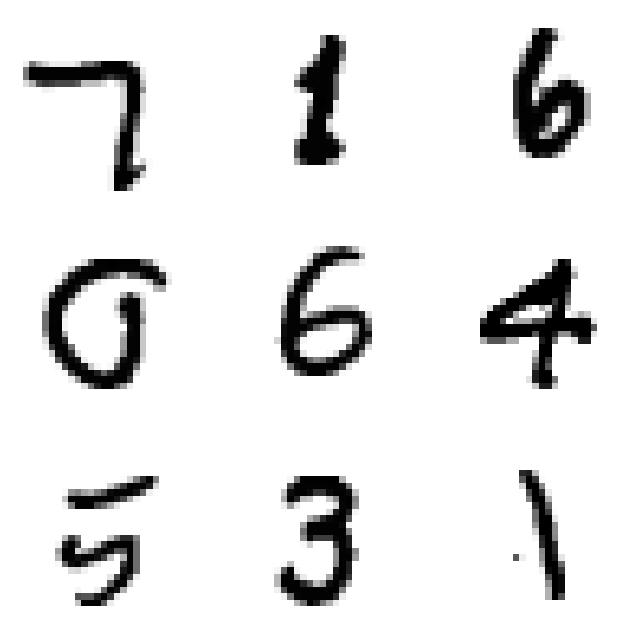

In [10]:
# Show Sample Data From Inverted Dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset_train_negative), size=(1,)).item()
    img, label = dataset_train_negative[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [11]:
# Combining Datasets

indices_noise = torch.randperm(len(dataset_train))[:int(len(dataset_train)/2)]
indices_negative = torch.randperm(len(dataset_train))[:int(len(dataset_train)/2)]
dataset_train_noise = Subset(dataset_train_noise, indices_noise)
dataset_train_negative = Subset(dataset_train_negative, indices_negative)
dataset_train_transformed = ConcatDataset([dataset_train_noise, dataset_train_negative])
data_train_transformed = DataLoader(dataset_train_transformed, batch_size=batch_size, shuffle=True, num_workers=int(cuda), pin_memory=cuda)

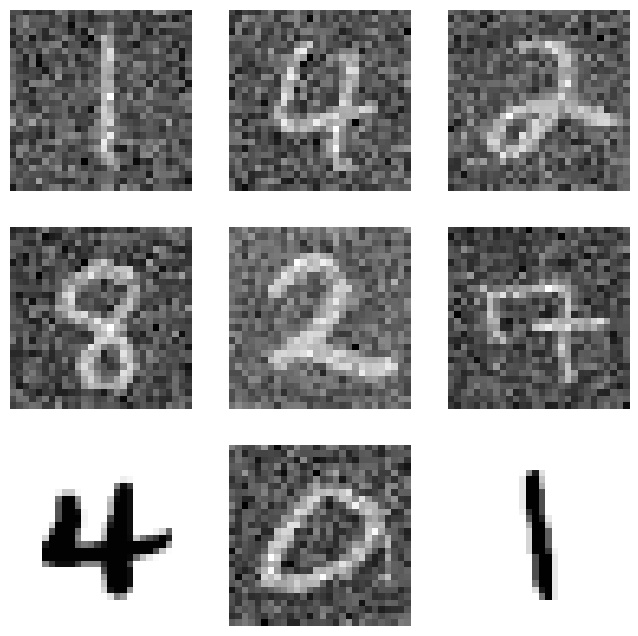

In [12]:
# Show Sample Data From Transformed Dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset_train_transformed), size=(1,)).item()
    img, label = dataset_train_transformed[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

**Model**

In [13]:
import torch.nn as nn
import torch

In [14]:
# Random seed
torch.manual_seed(seed)
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed_all(seed)

# Name of The Experiment
timestamp = str(int(time.time()))
if name == '':
    name = 'n_exp_{}_bs_{}_lri_{}_lre_{}_lrd_{}_ei_{}_e_{}_oi_{}_oe_{}_oe_{}_{}'.format(
        num_experts, batch_size, learning_rate_initialize,
        learning_rate_expert, learning_rate_discriminator, epochs_init,
        epochs, optimizer_initialize, optimizer_experts, optimizer_discriminator,
        timestamp)
else:
    name = '{}_{}'.format(name, timestamp)

print('\nExperiment: {}\n'.format(name))

# Logging. To run: tensorboard --logdir <args.outdir>/logs
log_dir = os.path.join(outdir, 'logs')
if not os.path.exists(log_dir):
    os.mkdir(log_dir)
log_dir_exp = os.path.join(log_dir, name)
os.mkdir(log_dir_exp)
writer = SummaryWriter(log_dir=log_dir_exp)

# Directory for checkpoints
checkpt_dir = os.path.join(outdir, 'checkpoints')
if not os.path.exists(checkpt_dir):
    os.mkdir(checkpt_dir)



Experiment: n_exp_5_bs_32_lri_0.1_lre_0.001_lrd_0.001_ei_100_e_100_oi_adam_oe_adam_oe_adam_1688125582



In [ ]:
# class Expert(nn.Module):

#     def __init__(self):
#         super(Expert, self).__init__()

#         # Architecture
#         def block(in_feat, out_feat, normalize=True):
#             layers = [nn.Linear(in_feat, out_feat)]
#             if normalize:
#                 layers.append(nn.BatchNorm1d(out_feat, 0.8))
#             layers.append(nn.LeakyReLU(0.2, inplace=True))
#             return layers

#         self.model = nn.Sequential(
#             *block(input_size, 128, normalize=False),
#             *block(128, 256),
#             *block(256, 512),
#             *block(512, 1024),
#             nn.Linear(1024, input_size),
#             nn.Tanh()
#             )

#     def forward(self, input):
#         output = self.model(input)
#         return output

In [15]:
class Expert(nn.Module):
    def __init__(self):
        super(Expert, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.elu1 = nn.ELU()

        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.elu2 = nn.ELU()

        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.elu3 = nn.ELU()

        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.elu4 = nn.ELU()

        self.conv5 = nn.Conv2d(32, 1, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.elu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.elu2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.elu3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.elu4(x)

        x = self.conv5(x)
        x = self.sigmoid(x)

        return x

In [ ]:
# class Discriminator(nn.Module):

#     def __init__(self):
#         super(Discriminator, self).__init__()

#         # Architecture
#         self.model = nn.Sequential(
#             nn.Linear(input_size, 512),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(512, 256),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(256, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, input):
#         validity = self.model(input)
#         return validity

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.elu1 = nn.ELU()

        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.elu2 = nn.ELU()

        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.elu3 = nn.ELU()

        self.pool1 = nn.AvgPool2d(kernel_size=2)

        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.elu4 = nn.ELU()

        self.conv5 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.elu5 = nn.ELU()

        self.pool2 = nn.AvgPool2d(kernel_size=2)

        self.conv6 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.elu6 = nn.ELU()

        self.conv7 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.elu7 = nn.ELU()

        self.pool3 = nn.AvgPool2d(kernel_size=2)

        self.fc1 = nn.Linear(64 * 3 * 3, 1024)
        self.elu8 = nn.ELU()

        self.fc2 = nn.Linear(1024, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.elu1(x)

        x = self.conv2(x)
        x = self.elu2(x)

        x = self.conv3(x)
        x = self.elu3(x)

        x = self.pool1(x)

        x = self.conv4(x)
        x = self.elu4(x)

        x = self.conv5(x)
        x = self.elu5(x)

        x = self.pool2(x)

        x = self.conv6(x)
        x = self.elu6(x)

        x = self.conv7(x)
        x = self.elu7(x)

        x = self.pool3(x)

        x = x.view(-1, 64 * 3 * 3)
        # x = x.view(-1, x.size()[0])

        x = self.fc1(x)
        x = self.elu8(x)

        x = self.fc2(x)
        x = self.sigmoid(x)

        return x

In [17]:
def initialize_expert(epochs, expert, i, optimizer, loss, data_train, writer):
    print("Initializing expert [{}] as identity on preturbed data".format(i+1))
    expert.train()
    for epoch in range(epochs):
        total_loss = 0
        n_samples = 0
        for batch in data_train:
            x_transformed, y = batch
            x_transformed = x_transformed.to(device)
            batch_size = x_transformed.size(0)
            n_samples += batch_size
            # x_transformed = x_transformed.view(x_transformed.size(0), -1).to(device)
            x_hat = expert(x_transformed)
            loss_rec = loss(x_hat, x_transformed)
            total_loss += loss_rec.item()*batch_size
            optimizer.zero_grad()
            loss_rec.backward()
            optimizer.step()

        # Loss
        mean_loss = total_loss/n_samples
        print("initialization epoch [{}] expert [{}] loss {:.4f}".format(epoch+1, i+1, mean_loss))
        writer.add_scalar('expert_{}_initialization_loss'.format(i+1), mean_loss, epoch+1)
        if mean_loss < 0.002:
            break

    torch.save(expert.state_dict(), checkpt_dir + '/{}_E_{}_init.pth'.format(name, i + 1))

In [35]:
def train_system(epoch, experts, discriminator, optimizers_E, optimizer_D, criterion, data_canonical, data_transformed, writer):
    discriminator.train()
    for i, expert in enumerate(experts):
        expert.train()

    # Labels for canonical vs transformed samples
    canonical_label = 1
    transformed_label = 0
    # Keep track of losses
    total_loss_D_canon = 0
    total_loss_D_transformed = 0
    n_samples = 0
    total_loss_expert = [0 for i in range(len(experts))]
    total_samples_expert = [0 for i in range(len(experts))]
    expert_scores_D = [0 for i in range(len(experts))]
    expert_winning_samples_idx = [[] for i in range(len(experts))]
    canon_iter = iter(data_canonical)
    # Iterate through data
    for idx, batch in enumerate(data_transformed):
        x_transf, y_transf = batch
        x_transf = x_transf.to(device)
        x_canon, y_canon = next(canon_iter)
        x_canon = x_canon.to(device)
        # x_transf = torch.randn(x_canon.size()) # TODO temporary since do not have the preturbed data yet
        batch_size = x_canon.size(0)
        n_samples += batch_size
        # x_canon = x_canon.view(batch_size, -1).to(device)
        # x_transf = x_transf.view(batch_size, -1).to(device)

        # Train Discriminator on canonical distribution
        scores_canon = discriminator(x_canon)
        labels_canon = torch.full((batch_size,), canonical_label, device=device).unsqueeze(dim=1)
        loss_D_canon = criterion(scores_canon, labels_canon.float())
        total_loss_D_canon += loss_D_canon.item() * batch_size
        optimizer_D.zero_grad()
        loss_D_canon.backward()

        # Train Discriminator on experts output
        labels_transf = torch.full((batch_size,), transformed_label, device=device).unsqueeze(dim=1)
        # loss_D_transformed = 0
        exp_outputs = []
        expert_scores = []
        for i, expert in enumerate(experts):
            exp_output = expert(x_transf)
            # exp_outputs.append(exp_output.view(batch_size, 1, input_size))
            exp_outputs.append(exp_output)
            exp_scores = discriminator(exp_output.detach())
            expert_scores.append(exp_scores)
            loss_D_transformed += criterion(exp_scores, labels_transf.float())
        loss_D_transformed = loss_D_transformed / num_experts
        total_loss_D_transformed += loss_D_transformed.item() * batch_size
        loss_D_transformed.backward()
        optimizer_D.step()

        # Train experts
        exp_outputs = torch.cat(exp_outputs, dim=1)
        expert_scores = torch.cat(expert_scores, dim=1)
        mask_winners = expert_scores.argmax(dim=1)

        # Update each expert on samples it won
        for i, expert in enumerate(experts):
            winning_indexes = mask_winners.eq(i).nonzero().squeeze(dim=-1)
            accrue = 0 if idx == 0 else 1
            expert_winning_samples_idx[i] += (winning_indexes+accrue*n_samples).tolist()
            n_expert_samples = winning_indexes.size(0)
            if n_expert_samples > 0:
                total_samples_expert[i] += n_expert_samples
                exp_samples = exp_outputs[winning_indexes, i]
                exp_samples = torch.unsqueeze(exp_samples, 1)
                D_E_x_transf = discriminator(exp_samples)
                exp_labels = torch.full((n_expert_samples,), canonical_label,
                                    device=device).unsqueeze(dim=1)
                # breakpoint()
                loss_E = criterion(D_E_x_transf, exp_labels.float())
                total_loss_expert[i] += loss_E.item() * n_expert_samples
                optimizers_E[i].zero_grad()
                loss_E.backward(retain_graph=True) # TODO figure out why retain graph is necessary
                optimizers_E[i].step()
                expert_scores_D[i] += D_E_x_transf.squeeze().sum().item()

    # Logging
    mean_loss_D_generated = total_loss_D_transformed / n_samples
    mean_loss_D_canon = total_loss_D_canon / n_samples
    print("epoch [{}] loss_D_transformed {:.4f}".format(epoch + 1, mean_loss_D_generated))
    print("epoch [{}] loss_D_canon {:.4f}".format(epoch + 1, mean_loss_D_canon))
    writer.add_scalar('loss_D_canonical', mean_loss_D_canon, epoch + 1)
    writer.add_scalar('loss_D_transformed', mean_loss_D_generated, epoch + 1)
    for i in range(len(experts)):
        print("epoch [{}] expert [{}] n_samples {}".format(epoch + 1, i + 1, total_samples_expert[i]))
        writer.add_scalar('expert_{}_n_samples'.format(i + 1), total_samples_expert[i], epoch + 1)
        writer.add_text('expert_{}_winning_samples'.format(i + 1),
                           ":".join([str(j) for j in expert_winning_samples_idx[i]]), epoch + 1)
        if total_samples_expert[i]> 0:
            mean_loss_expert = total_loss_expert[i] / total_samples_expert[i]
            mean_expert_scores = expert_scores_D[i] / total_samples_expert[i]
            print("epoch [{}] expert [{}] loss {:.4f}".format(epoch + 1, i + 1, mean_loss_expert))
            print("epoch [{}] expert [{}] scores {:.4f}".format(epoch + 1, i + 1, mean_expert_scores))
            writer.add_scalar('expert_{}_loss'.format(i + 1), mean_loss_expert, epoch + 1)
            writer.add_scalar('expert_{}_scores'.format(i + 1), mean_expert_scores, epoch + 1)

In [19]:
def init_weights(model, path):
    pre_trained_dict = torch.load(path, map_location=lambda storage, loc: storage)
    for layer in pre_trained_dict.keys():
        model.state_dict()[layer].copy_(pre_trained_dict[layer])
    for param in model.parameters():
        param.requires_grad = True

In [20]:
# Model
experts = [Expert().to(device) for i in range(num_experts)]
discriminator = Discriminator().to(device)

In [21]:
# Losses
loss_initial = torch.nn.MSELoss(reduction='mean')
criterion = torch.nn.BCELoss(reduction='mean')

In [ ]:
# Initialize Experts as approximately Identity on Transformed Data
for i, expert in enumerate(experts):
    if load_initialized_experts:
        path = os.path.join(checkpt_dir,
                            model_for_initialized_experts + '_E_{}_init.pth'.format(i+1))
        init_weights(expert, path)
    else:
        if optimizer_initialize == 'adam':
            optimizer_E = torch.optim.Adam(expert.parameters(), lr=learning_rate_initialize,
                                                weight_decay=weight_decay)
        elif optimizer_initialize == 'sgd':
            optimizer_E = torch.optim.SGD(expert.parameters(), lr=learning_rate_initialize,
                                              weight_decay=weight_decay)
        else:
            raise NotImplementedError
        initialize_expert(epochs_init, expert, i, optimizer_E, loss_initial, data_train_transformed, writer)


Initializing expert [1] as identity on preturbed data
initialization epoch [1] expert [1] loss 1.9262
initialization epoch [2] expert [1] loss 1.8949
initialization epoch [3] expert [1] loss 1.8938
initialization epoch [4] expert [1] loss 1.8934
initialization epoch [5] expert [1] loss 1.8933
initialization epoch [6] expert [1] loss 1.8930
initialization epoch [7] expert [1] loss 1.8932
initialization epoch [8] expert [1] loss 1.8927
initialization epoch [9] expert [1] loss 1.8927
initialization epoch [10] expert [1] loss 1.8924
initialization epoch [11] expert [1] loss 1.8928
initialization epoch [12] expert [1] loss 1.8921
initialization epoch [13] expert [1] loss 1.8924
initialization epoch [14] expert [1] loss 1.8981
initialization epoch [15] expert [1] loss 1.9060
initialization epoch [16] expert [1] loss 1.9038
initialization epoch [17] expert [1] loss 1.9034
initialization epoch [18] expert [1] loss 1.9025
initialization epoch [19] expert [1] loss 1.9021
initialization epoch [20

In [23]:
# Optimizers
optimizers_E = []
for i in range(num_experts):
    if optimizer_experts == 'adam':
        optimizer_E = torch.optim.Adam(experts[i].parameters(), lr=learning_rate_expert,
                                        weight_decay=weight_decay)
    elif optimizer_experts == 'sgd':
        optimizer_E = torch.optim.SGD(experts[i].parameters(), lr=learning_rate_expert,
                                      weight_decay=weight_decay)
    else:
        raise NotImplementedError
    optimizers_E.append(optimizer_E)

if optimizer_discriminator == 'adam':
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate_discriminator,
                                    weight_decay=weight_decay)
elif optimizer_discriminator == 'sgd':
    optimizer_D = torch.optim.SGD(discriminator.parameters(), lr=learning_rate_discriminator,
                                    weight_decay=weight_decay)

In [ ]:
print(discriminator)

Discriminator(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu1): ELU(alpha=1.0)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu2): ELU(alpha=1.0)
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu3): ELU(alpha=1.0)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu4): ELU(alpha=1.0)
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu5): ELU(alpha=1.0)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu6): ELU(alpha=1.0)
  (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu7): ELU(alpha=1.0)
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (elu8): ELU(alpha=1.0)
  (fc2): Lin

In [36]:
# Training
torch.autograd.set_detect_anomaly(True)
for epoch in range(epochs):
    train_system(epoch, experts, discriminator, optimizers_E, optimizer_D, criterion, data_train, data_train_transformed, writer)

    if epoch % log_interval == 0 or epoch == epochs-1:
        torch.save(discriminator.state_dict(), checkpt_dir + '/{}_D.pth'.format(name))
        for i in range(num_experts):
            torch.save(experts[i].state_dict(), checkpt_dir + '/{}_E_{}.pth'.format(name, i+1))

UnboundLocalError: ignored

In [ ]:
# pool of square window of size=3, stride=2
# m = nn.AvgPool2d(3, stride=2)
# pool of non-square window
m = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
input = torch.randn(32, 1, 64, 64)
output = m(input)

In [ ]:
# output.shape
output.view(output.size()[0], -1).shape

torch.Size([32, 1024])

In [ ]:
exp = Discriminator()
aa_x, aa_y = next(iter(data_train))
bb = exp(aa_x)

RuntimeError: ignored

In [ ]:
conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
elu1 = nn.ELU()

conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
elu2 = nn.ELU()

conv3 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
elu3 = nn.ELU()

pool1 = nn.AvgPool2d(kernel_size=2)

conv4 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
elu4 = nn.ELU()

conv5 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
elu5 = nn.ELU()

pool2 = nn.AvgPool2d(kernel_size=2)

conv6 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
elu6 = nn.ELU()

conv7 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
elu7 = nn.ELU()

pool3 = nn.AvgPool2d(kernel_size=2)

fc1 = nn.Linear(64 * 3 * 3, 1024)
elu8 = nn.ELU()

fc2 = nn.Linear(1024, 1)
sigmoid = nn.Sigmoid()

x, y = next(iter(data_train))
print(x.shape)
x = conv1(x)
print(x.shape)
x = elu1(x)
print(x.shape)
x = conv2(x)
print(x.shape)
x = elu2(x)
print(x.shape)
x = conv3(x)
print(x.shape)
x = elu3(x)
print(x.shape)
x = pool1(x)
print('pooling')
print(x.shape)
x = conv4(x)
print(x.shape)
x = elu4(x)
print(x.shape)
x = conv5(x)
print(x.shape)
x = elu5(x)
print(x.shape)
x = pool2(x)
print('pooling')
print(x.shape)
x = conv6(x)
print(x.shape)
x = elu6(x)
print(x.shape)
x = conv7(x)
print(x.shape)
x = elu7(x)
print(x.shape)

x = pool3(x)
print('pooling')
print(x.shape)
x = x.view(-1, 64 * 3 * 3)
# x = x.view(-1, x.size()[0])
print(x.shape)
x = fc1(x)
x = elu8(x)
print(x.shape)
x = fc2(x)
print(x.shape)
x = sigmoid(x)

torch.Size([32, 1, 28, 28])
torch.Size([32, 16, 28, 28])
torch.Size([32, 16, 28, 28])
torch.Size([32, 16, 28, 28])
torch.Size([32, 16, 28, 28])
torch.Size([32, 16, 28, 28])
torch.Size([32, 16, 28, 28])
pooling
torch.Size([32, 16, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
pooling
torch.Size([32, 32, 7, 7])
torch.Size([32, 64, 7, 7])
torch.Size([32, 64, 7, 7])
torch.Size([32, 64, 7, 7])
torch.Size([32, 64, 7, 7])
pooling
torch.Size([32, 64, 3, 3])
torch.Size([32, 576])
torch.Size([32, 1024])
torch.Size([32, 1])


In [ ]:
labels = torch.full((batch_size,), 1, device=device).unsqueeze(dim=1)
labels.float()

In [44]:
# [32, 5, 28, 28]
# exp_outputs[winning_indexes, i]
a = torch.randn(3 , 5, 28, 28)
index = [0,2]
a.shape
b = a[index,1]
b.shape
b = torch.unsqueeze(b, 1)
b.shape


torch.Size([2, 1, 28, 28])